# NRC-35: OTE Water Ice Measurements with NIRCam

This activity will use NIRCam longwave grism spectra to check for ice contamination associated with the telescope and instrument cooldown.

## Part 1: Simulations

In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline

# Program bar
from tqdm.auto import trange, tqdm

In [2]:
from nrc35 import *

pyNRC log messages of level WARN and above will be shown.
pyNRC log outputs will be directed to the screen.


## OTE Ice Observations

1. Post LOS-02 pointing and background check **(L+40; OTE = Initial Deployment)**
 1. 31: Pointing Pre-Check (HD 84406)
 1. 32: Bgrd Levels Sub256 Pre-Check (HD 84406)
 1. 33: Star Levels Sub256 Pre-Check (HD 84406)
 1. 34: Bgrd Levels Sub64 Pre-Check (HD 84406)
 1. 35: Dark and Bias Pre-Check
1. Analysis Time **(6 hours)**
1. Pre FSM heater off NIRCam with Beam Probing **(L+40; OTE = Initial Deployment)**
 1. 1: LW Grism Ice Monitor #1 Mod-A 256 subarray (HD 84406)
 1. 22: Module A GrismR -V2 1 column 2 pts (HD 84406)
 1. 23: Module A GrismC +V2 1 pt (HD 84406)
 1. 24: Module B GrismR 256 subarray (HD 84406)
 1. 25: Module B GrismR +V2 1 column 2 pts (HD 84406)
 1. 26: Module B GrismC -V2 1 pt (HD 84406)
1. Post-FSM heater off NIRCam Observations
 1. 2: LW Grism Ice Monitor #2 (HD 84406) **(L+43; OTE = Initial Deployment)**
 1. 3: LW Grism Ice Monitor #3 (HD 84406) **(L+47; OTE = Segment Image Array 1)**
 1. 4: LW Grism Ice Monitor #4 (HD 84406) **(L+50; OTE = Global Alignment 1)**
 1. 5: LW Grism Ice Monitor #5 (BD+86-189) **(L+54; OTE = Image Stacking 1)**
 1. 6: LW Grism Ice Monitor #6 (TYC-8558-1141-1) **(L+58; OTE = Coarse Phasing 1)**
 1. 7: LW Grism Ice Monitor #7 (GCRV-21765) **(L+67; OTE = Fine Phasing 1)**
 1. 8: LW Grism Ice Monitor #8 (GCRV-21765) **(L+77; OTE = MIMF)**
 1. 9: LW Grism Ice Monitor #9 (GCRV-21765) **(L+96; OTE = MIMF)**

In [3]:
print(opd_dir)
print(darks_80K_dir)
print(save_dir)

/home/jarronl/data/NIRData/NIRCam/OTE_OPDs/
/home/jarronl/data/NIRData/NIRCam/NRC_80K/
/home/jarronl/data/NIRData/NRC_Sims/Sim_NRC35/


In [4]:
# Initialize observation dictionary
obs_dict = init_obs_dict(opd_dir)

In [5]:
# Store obs_params and visit info in in obs_dict
#   obs_dict[vkey]['obs_params']
#   obs_dict[vkey]['visit']

init_visits(obs_dict, rand_seed_init=1234)

  Creating Observation Parameters...


Visits:   0%|          | 0/18 [00:00<?, ?it/s]

## Select Any Visit

In [6]:
vkey = '001:001'

In [7]:
# Create NIRCam instrument class:
#   obs_dict[vkey]['nrc']
kw_scales = {'ote_scale': 0.5, 'nc_scale': 0.5, 'ice_scale': None, 'nvr_scale': None}
add_inst(obs_dict, key=vkey, **kw_scales)

  Generating Instrument Classes...


Monochromatic PSFs:   0%|          | 0/21 [00:00<?, ?it/s]

In [8]:
d = obs_dict[vkey]
nrc = d['nrc']

In [9]:
print(nrc.filter, nrc.pupil_mask, nrc.image_mask)

F322W2 GRISMR None


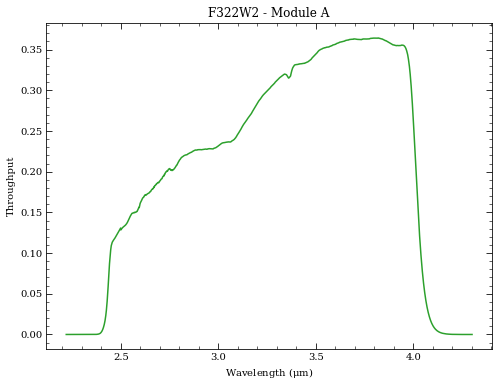

In [10]:
# Check that bandpass looks good
nrc = obs_dict[vkey]['nrc']
nrc.plot_bandpass();

In [12]:
# Create slope and check extraction
#   obs_dict[vkey]['im_slope_ideal']
#   obs_dict[vkey]['bg_slope']
#   obs_dict[vkey]['im_bias']
#   obs_dict[vkey]['im_dark']
add_slope_images(obs_dict, key=vkey, spec_ang=0)

  Creating ideal slopes, FSM background, SCA darks, biases...


Filters:   0%|          | 0/29 [00:00<?, ?it/s]

  Exposure: 1


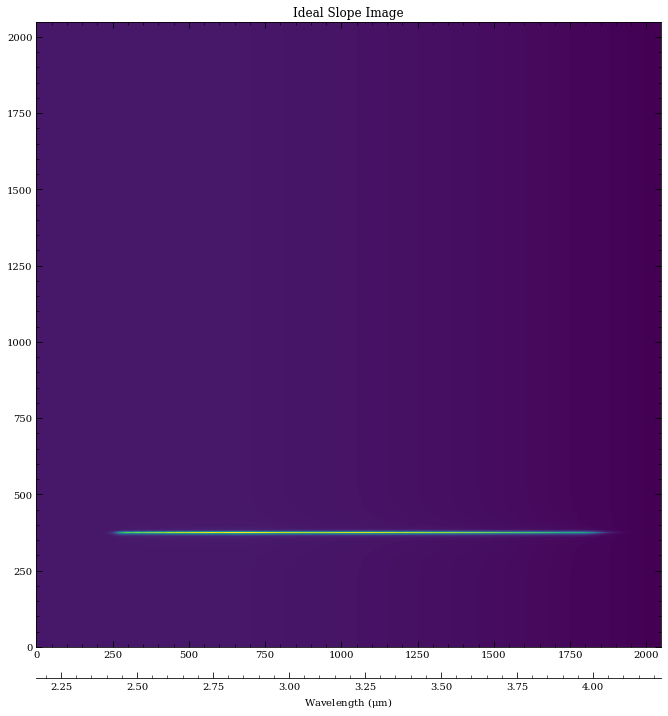

In [13]:
# Verify slope image looks right
if nrc.is_grism:
    
    if nrc.Detector.ypix==256:
        fig, ax = plt.subplots(1,1, figsize=(14,2.5))
        ax2_scl = -0.25
    else:
        fig, ax = plt.subplots(1,1, figsize=(10,10))
        ax2_scl = -0.05

    im = obs_dict[vkey]['im_slope_ideal'] + obs_dict[vkey]['bg_slope']
    wave = obs_dict[vkey]['wave'][0].mean(axis=0)

    extent = [wave.min(), wave.max(), ]
    ax.imshow(im)
    ax.set_title('Ideal Slope Image')

    def x_to_um(x):
        dw = wave[1] - wave[0]
        return x*dw + wave[0]

    def um_to_x(w):
        dw = wave[1] - wave[0]
        return (w - wave[0]) / dw

    ax2 = ax.secondary_xaxis(ax2_scl, functions=(x_to_um, um_to_x))
    str_um = '$\mathdefault{\mu m}$'
    ax2.set_xlabel(f'Wavelength ({str_um})')

    fig.tight_layout()

else:
    im = obs_dict[vkey]['im_slope_ideal']
    plt.imshow(im**0.25)

In [14]:
# Create and save DMS FITS files
params_noise = {
    'include_poisson'   : True,     # Photon Noise
    'include_dark'      : True,     # Dark current
    'include_bias'      : True,     # Bias image offset
    'include_ktc'       : True,     # kTC Noise
    'include_rn'        : True,     # Read Noise
    'include_cpink'     : True,     # Correlated 1/f noise between channel
    'include_upink'     : True,     # Channel-dependent 1/f noise
    'include_acn'       : True,     # Alternating column noise
    'apply_ipc'         : True,     # Interpixel capacitance
    'apply_ppc'         : True,     # Post-pixel coupling
    'amp_crosstalk'     : True,     # Amplifier crosstalk
    'include_refoffsets': True,     # Reference offsets
    'include_refinst'   : True,     # Reference pixel instabilities
    'include_colnoise'  : True,     # Transient detector column noise
    'add_crs'           : True,     # Include cosmic ray
    'cr_model'          : 'SUNMAX', # Cosmic ray model ('SUNMAX', 'SUNMIN', or 'FLARES')
    'cr_scale'          : 1,        # Cosmic ray probabilities scaling
    'apply_nonlinearity': True,     # Apply non-linearity
    'random_nonlin'     : True,     # Add randomness to non-linearity
    'apply_flats'       : True,     # pixel-to-pixel QE variations and field-dep illum
}

run_all_exps(obs_dict, key=vkey, rand_seed_init=12345, 
             save_dir=save_dir, save_slope=True, **params_noise)

  Creating ideal slopes, FSM background, SCA darks, biases...


Filters:   0%|          | 0/29 [00:00<?, ?it/s]

  Exposure: 1
  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC35/slope_jw01409001001_02101_00001_nrca5_uncal.fits


PPC Amps:   0%|          | 0/4 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

PPC Amps:   0%|          | 0/4 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Ramps:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC35/jw01409001001_02101_00001_nrca5_uncal.fits
  Creating ideal slopes, FSM background, SCA darks, biases...


Filters:   0%|          | 0/29 [00:00<?, ?it/s]

  Exposure: 2
  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC35/slope_jw01409001001_02101_00002_nrca5_uncal.fits


PPC Amps:   0%|          | 0/4 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

PPC Amps:   0%|          | 0/4 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Ramps:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC35/jw01409001001_02101_00002_nrca5_uncal.fits


## Visit 001:001

In [6]:
vkey = '001:001'

In [7]:
# Create NIRCam instrument class:
#   obs_dict[vkey]['nrc']
kw_scales = {'ote_scale': 0.5, 'nc_scale': 0.5, 'ice_scale': None, 'nvr_scale': None}
add_inst(obs_dict, key=vkey, **kw_scales)

  Generating Instrument Classes...


Monochromatic PSFs:   0%|          | 0/21 [00:00<?, ?it/s]

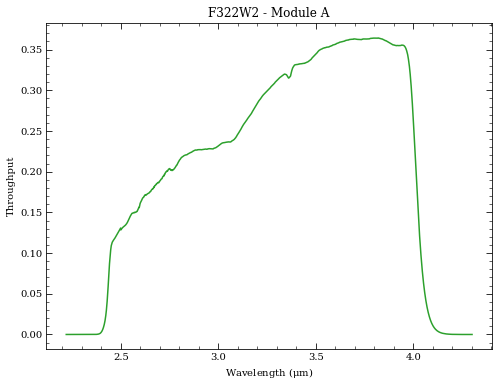

In [8]:
# Check that bandpass looks good
nrc = obs_dict[vkey]['nrc']
nrc.plot_bandpass();

In [9]:
# Create slope and check extraction
#   obs_dict[vkey]['wave']
#   obs_dict[vkey]['im_slope_ideal']
#   obs_dict[vkey]['bg_slope']
#   obs_dict[vkey]['im_bias']
#   obs_dict[vkey]['im_dark']
add_slope_images(obs_dict, key=vkey, spec_ang=0)

  Creating ideal slopes, FSM background, SCA darks, biases...


Filters:   0%|          | 0/29 [00:00<?, ?it/s]

  Exposure: 1


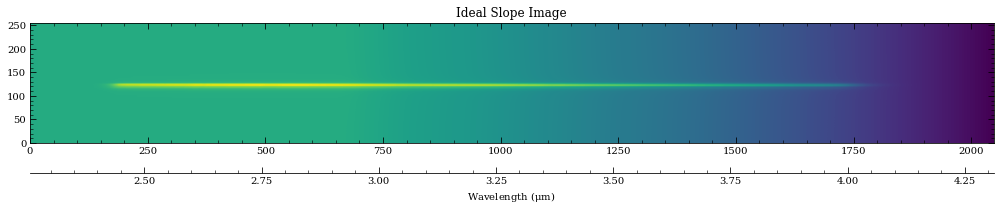

In [10]:
# Verify slope image looks right

fig, ax = plt.subplots(1,1, figsize=(14,2.5))

im = obs_dict[vkey]['im_slope_ideal'] + obs_dict[vkey]['bg_slope']
wave = obs_dict[vkey]['wave'][0].mean(axis=0)

extent = [wave.min(), wave.max(), ]
ax.imshow(im)
ax.set_title('Ideal Slope Image')

def x_to_um(x):
    dw = wave[1] - wave[0]
    return x*dw + wave[0]

def um_to_x(w):
    dw = wave[1] - wave[0]
    return (w - wave[0]) / dw

ax2 = ax.secondary_xaxis(-0.25, functions=(x_to_um, um_to_x))
str_um = '$\mathdefault{\mu m}$'
ax2.set_xlabel(f'Wavelength ({str_um})')

fig.tight_layout()

In [12]:
# Double-check source table
d = obs_dict[vkey]
d['src_tbl']

index,ra,dec,K-Band,dist,SpType,F070W,F090W,F115W,F140M,F150W,F150W2,F162M,F164N,F182M,F187N,F200W,F210M,F212N,F250M,F277W,F300M,F322W2,F323N,F335M,F356W,F360M,F405N,F410M,F430M,F444W,F460M,F466N,F470N,F480M
,deg,deg,mag,arcsec,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag
int64,float64,float64,float32,float32,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,146.87727491,63.24780476,4.698,2.7190957,G5V,5.779,5.478,5.217,4.917,4.842,4.936,4.743,4.711,4.719,4.703,4.712,4.701,4.703,4.7,4.688,4.682,4.686,4.686,4.684,4.684,4.683,4.663,4.683,4.691,4.701,4.724,4.695,4.72,4.717
2,146.81478027,63.28792868,13.924,177.17578,G2V,14.82,14.569,14.352,14.095,14.035,14.121,13.956,13.931,13.942,13.93,13.936,13.926,13.928,13.92,13.914,13.913,13.914,13.917,13.915,13.915,13.915,13.898,13.914,13.917,13.922,13.931,13.905,13.928,13.927
3,146.84271400,63.31572700,13.676,252.55495,G2V,14.572,14.321,14.104,13.847,13.787,13.873,13.708,13.683,13.694,13.682,13.688,13.678,13.68,13.672,13.666,13.665,13.666,13.669,13.667,13.667,13.667,13.65,13.666,13.669,13.674,13.683,13.657,13.68,13.679
4,146.95336467,63.17027856,13.736,303.92145,G2V,14.632,14.381,14.164,13.907,13.847,13.933,13.768,13.743,13.754,13.742,13.748,13.738,13.74,13.732,13.726,13.725,13.726,13.729,13.727,13.727,13.727,13.71,13.726,13.729,13.734,13.743,13.717,13.74,13.739


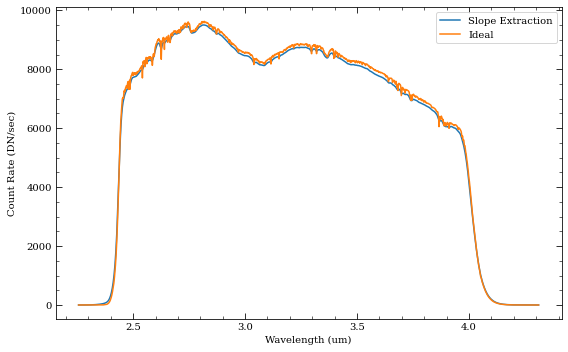

In [19]:
# Extract spectrum
# No noise, so just sum full spectrum
im_slope     = obs_dict[vkey]['im_slope_ideal']
spec_extract = im_slope.sum(axis=0)[::-1]
wspec        = wave[0].mean(axis=0)[::-1]

# pysynphot observation of spectrum plus bandpass
bp = nrc.bandpass
sp = pynrc.stellar_spectrum(src_tbl[0]['SpType'], src_tbl[0][bp.name], 'vegamag', bp)
# Rebin spectrum
sp = nrc_utils.bin_spectrum(sp, np.sort(wspec), waveunits='um')

obs = S.Observation(sp, bp, binset=sp.wave, force='taper')
obs.convert('counts')

# Plot
fig, ax = plt.subplots(1,1, figsize=(8,5))

ax.plot(wspec, spec_extract, label='Slope Extraction')
ax.plot(obs.binwave/1e4, obs.binflux, label='Ideal')

ax.set_xlabel('Wavelength (um)')
ax.set_ylabel('Count Rate (DN/sec)')

ax.legend()

fig.tight_layout()

In [13]:
# Create and save DMS FITS files
params_noise = {
    'include_poisson'   : True,     # Photon Noise
    'include_dark'      : True,     # Dark current
    'include_bias'      : True,     # Bias image offset
    'include_ktc'       : True,     # kTC Noise
    'include_rn'        : True,     # Read Noise
    'include_cpink'     : True,     # Correlated 1/f noise between channel
    'include_upink'     : True,     # Channel-dependent 1/f noise
    'include_acn'       : True,     # Alternating column noise
    'apply_ipc'         : True,     # Interpixel capacitance
    'apply_ppc'         : True,     # Post-pixel coupling
    'amp_crosstalk'     : True,     # Amplifier crosstalk
    'include_refoffsets': True,     # Reference offsets
    'include_refinst'   : True,     # Reference pixel instabilities
    'include_colnoise'  : True,     # Transient detector column noise
    'add_crs'           : True,     # Include cosmic ray
    'cr_model'          : 'SUNMAX', # Cosmic ray model ('SUNMAX', 'SUNMIN', or 'FLARES')
    'cr_scale'          : 1,        # Cosmic ray probabilities scaling
    'apply_nonlinearity': True,     # Apply non-linearity
    'random_nonlin'     : True,     # Add randomness to non-linearity
    'apply_flats'       : True,     # pixel-to-pixel QE variations and field-dep illum
}

run_all_exps(obs_dict, key=vkey, rand_seed_init=1234, 
             save_dir=save_dir, save_slope=True, **params_noise)

  Creating ideal slopes, FSM background, SCA darks, biases...


Filters:   0%|          | 0/29 [00:00<?, ?it/s]

  Exposure: 1
  Saving: /Users/jarron/NIRCam/Data/NRC_Sims/Sim_NRC35/slope_jw01409001001_02101_00001_nrca5_uncal.fits


PPC Amps:   0%|          | 0/4 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

PPC Amps:   0%|          | 0/4 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Ramps:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/5 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/5 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/5 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/5 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/5 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/5 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/5 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/5 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/5 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/5 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  Saving: /Users/jarron/NIRCam/Data/NRC_Sims/Sim_NRC35/jw01409001001_02101_00001_nrca5_uncal.fits
  Creating ideal slopes, FSM background, SCA darks, biases...


Filters:   0%|          | 0/29 [00:00<?, ?it/s]

  Exposure: 2
  Saving: /Users/jarron/NIRCam/Data/NRC_Sims/Sim_NRC35/slope_jw01409001001_02101_00002_nrca5_uncal.fits


PPC Amps:   0%|          | 0/4 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

PPC Amps:   0%|          | 0/4 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Ramps:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/5 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/5 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/5 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/5 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/5 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/5 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/5 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/5 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/5 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/5 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  Saving: /Users/jarron/NIRCam/Data/NRC_Sims/Sim_NRC35/jw01409001001_02101_00002_nrca5_uncal.fits


## Visit 031:001

In [14]:
vkey = '031:001'

In [15]:
# Create NIRCam instrument class:
#   obs_dict[vkey]['nrc']
kw_scales = {'ote_scale': 0.5, 'nc_scale': 0.5, 'ice_scale': None, 'nvr_scale': None}
add_inst(obs_dict, key=vkey, **kw_scales)

  Generating Instrument Classes...


Monochromatic PSFs:   0%|          | 0/5 [00:00<?, ?it/s]

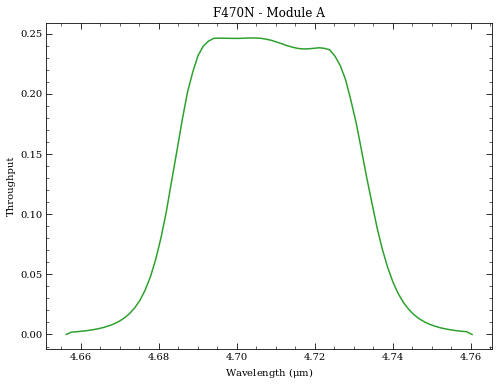

In [16]:
# Check that bandpass looks good
nrc = obs_dict[vkey]['nrc']
nrc.plot_bandpass();

In [17]:
# Create slope and check extraction
#   obs_dict[vkey]['im_slope_ideal']
#   obs_dict[vkey]['bg_slope']
#   obs_dict[vkey]['im_bias']
#   obs_dict[vkey]['im_dark']
add_slope_images(obs_dict, key=vkey, spec_ang=0)

  Creating ideal slopes, FSM background, SCA darks, biases...


Filters:   0%|          | 0/29 [00:00<?, ?it/s]

  Exposure: 1


PSFs:   0%|          | 0/25 [00:00<?, ?it/s]

Convolution:   0%|          | 0/25 [00:00<?, ?it/s]

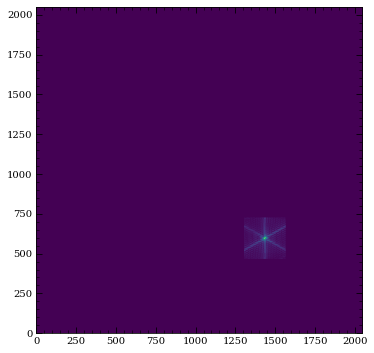

In [18]:
im = obs_dict[vkey]['im_slope_ideal']

plt.imshow(im**0.25)

In [19]:
# Create and save DMS FITS files
params_noise = {
    'include_poisson'   : True,     # Photon Noise
    'include_dark'      : True,     # Dark current
    'include_bias'      : True,     # Bias image offset
    'include_ktc'       : True,     # kTC Noise
    'include_rn'        : True,     # Read Noise
    'include_cpink'     : True,     # Correlated 1/f noise between channel
    'include_upink'     : True,     # Channel-dependent 1/f noise
    'include_acn'       : True,     # Alternating column noise
    'apply_ipc'         : True,     # Interpixel capacitance
    'apply_ppc'         : True,     # Post-pixel coupling
    'amp_crosstalk'     : True,     # Amplifier crosstalk
    'include_refoffsets': True,     # Reference offsets
    'include_refinst'   : True,     # Reference pixel instabilities
    'include_colnoise'  : True,     # Transient detector column noise
    'add_crs'           : True,     # Include cosmic ray
    'cr_model'          : 'SUNMAX', # Cosmic ray model ('SUNMAX', 'SUNMIN', or 'FLARES')
    'cr_scale'          : 1,        # Cosmic ray probabilities scaling
    'apply_nonlinearity': True,     # Apply non-linearity
    'random_nonlin'     : True,     # Add randomness to non-linearity
    'apply_flats'       : True,     # pixel-to-pixel QE variations and field-dep illum
}

run_all_exps(obs_dict, key=vkey, rand_seed_init=1234, 
             save_dir=save_dir, save_slope=True, **params_noise)

  Creating ideal slopes, FSM background, SCA darks, biases...


Filters:   0%|          | 0/29 [00:00<?, ?it/s]

  Exposure: 1


PSFs:   0%|          | 0/25 [00:00<?, ?it/s]

Convolution:   0%|          | 0/25 [00:00<?, ?it/s]

  Saving: /Users/jarron/NIRCam/Data/NRC_Sims/Sim_NRC35/slope_jw01409031001_02101_00001_nrca5_uncal.fits


PPC Amps:   0%|          | 0/4 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

PPC Amps:   0%|          | 0/4 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Ramps:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  Saving: /Users/jarron/NIRCam/Data/NRC_Sims/Sim_NRC35/jw01409031001_02101_00001_nrca5_uncal.fits
  Creating ideal slopes, FSM background, SCA darks, biases...


Filters:   0%|          | 0/29 [00:00<?, ?it/s]

  Exposure: 2


PSFs:   0%|          | 0/25 [00:00<?, ?it/s]

Convolution:   0%|          | 0/25 [00:00<?, ?it/s]

  Saving: /Users/jarron/NIRCam/Data/NRC_Sims/Sim_NRC35/slope_jw01409031001_02101_00002_nrca5_uncal.fits


PPC Amps:   0%|          | 0/4 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

PPC Amps:   0%|          | 0/4 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Ramps:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  Saving: /Users/jarron/NIRCam/Data/NRC_Sims/Sim_NRC35/jw01409031001_02101_00002_nrca5_uncal.fits


# Extra Backup Cells

In [41]:
d = obs_dict['001:001']
obs_params = d['obs_params']
visit = d['visit']

In [42]:
visit

{'obs_num': 1,
 'visit_num': 1,
 'visit_start': 23416,
 'slew_duration': 1800,
 'visit_duration': 1167,
 'exp_start_times': array([1800, 2310]),
 'orient_info': {'OrientMin': 190.0, 'OrientMax': 210.0},
 'APTTemplate': 'NircamEngineeringImaging',
 'PrimaryDitherType': array(['NONE', 'NONE'], dtype='<U4'),
 'PrimaryDithers': array(['NONE', 'NONE'], dtype='<U4'),
 'DitherSize': array(['NONE', 'NONE'], dtype='<U4'),
 'SubpixelPositions': array(['1', '1'], dtype='<U1'),
 'SubpixelDitherType': array(['STANDARD', 'STANDARD'], dtype='<U8'),
 'SmallGridDitherType': array(['NONE', 'NONE'], dtype='<U4'),
 'DitherPatternType': array(['NONE', 'NONE'], dtype='<U4'),
 'ImageDithers': array(['NONE', 'NONE'], dtype='<U4'),
 'number_of_dithers': array(['1', '1'], dtype='<U1'),
 'rand_seed_init': 1234,
 'rand_seed_dith': 3853010524,
 'rand_seed_noise': 3709225223,
 'TargetID': array(['HD-84406', 'HD-84406'], dtype='<U15'),
 'TargetRA': array(['09:47:30.2970', '09:47:30.2970'], dtype='<U13'),
 'TargetDec

In [43]:
obs_params

{'pi_name': 'Erin Smith',
 'title': 'CAR_NIRCAM-0035: NIRCAM Ice Measurement',
 'category': 'COM',
 'sub_category': 'NIRCAM',
 'science_category': 'Stellar Physics',
 'target_name': 'HD-84406',
 'catalog_name': 'UNKNOWN',
 'ra': 146.8762375,
 'dec': 63.24721111111111,
 'pa_v3': 196.9098730681069,
 'roll_offset': 0,
 'solar_elong': 133.21178164562465,
 'pitch_ang': 43.211781645624654,
 'siaf_ap': <pysiaf.Aperture object AperName=NRCA5_GRISM256_F322W2 >,
 'ra_obs': 146.87577594106958,
 'dec_obs': 63.246586256447664,
 'siaf_ap_ref': <pysiaf.Aperture object AperName=NRCA5_GRISM256_F322W2 >,
 'ra_ref': 146.87577594106958,
 'dec_ref': 63.246586256447664,
 'date-obs': '2022-02-01',
 'time-obs': '00:20:00.000',
 'obs_id_info': {'program_number': '01409',
  'observation_number': '001',
  'visit_number': '001',
  'visit_group': '02',
  'sequence_id': '1',
  'activity_id': '01',
  'exposure_number': '00001',
  'visit_id': '01409001001',
  'obs_id': 'V01409001001P0000000002101'},
 'obs_label': 'LW